In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

import numpy as np

import rebound


In [2]:
def zeroTo360(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

def min180To180(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

## Test stability of HD 52265's candidate 2-planet system.

In [3]:
sim = rebound.Simulation()
sim.add(m=1.0)
sim.add(m=0.001078685, a=0.5, e=0.213, omega=-2.12644 * 180/np.pi)
sim.add(m=0.000315014, a=2.6, e=0.657, omega=2.9857 * 180/np.pi)

# sim.add(m=3.963604e-5, a=0.05, e=0.05, omega=90)
# sim.add(m=0.00016851321, a=0.12, e=0.32, omega=0)

sim.move_to_com()
os = sim.calculate_orbits()

sim.integrator = "whfast"
sim.dt = 0.2 * os[0].P     # 20% of inner period = 0.2*119 d = 24 d
print(sim.dt)
Nout = int(1e5)             # number of points to display
tmax = 1e7*365.25          # let the simulation run for 1e7 years
Npl = 2
labels = ['b', 'c']

# sim.automateSimulationArchive("simulationarchive.bin", walltime=1.,deletefile=True)

sim.status()

0.44404886394138743
---------------------------------
REBOUND version:     	3.8.2
REBOUND built on:    	Apr 11 2019 23:00:47
Number of particles: 	3
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.444049
---------------------------------
<rebound.Particle object, m=1.0 x=0.0002864811444789382 y=-8.8290228380938e-06 z=0.0 vx=-0.0007747829424639019 vy=0.0014009672668286472 vz=0.0>
<rebound.Particle object, m=0.001078685 x=-0.3041793345043254 y=-0.2492934396615782 z=0.0 vx=1.112091209402604 vy=-1.3578070929458597 vz=0.0>
<rebound.Particle object, m=0.000315014 x=0.13216092288234824 y=0.8816691220055086 z=0.0 vx=-1.348553282554255 vy=0.20214618152100483 vz=0.0>
---------------------------------


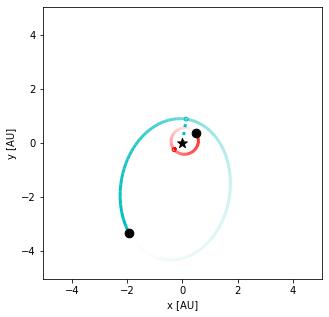

In [ ]:
for i in range(10**5): # 24*10**5 d = 6,571 yr
    sim.integrate(sim.t+1)
    fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]", lw=3, periastron=True)
    display(fig)
    plt.close(fig)
    clear_output(wait=True)

## Do the same for HD 164922. Rule out resonance.

In [4]:
x = np.zeros((Npl, Nout))
ecc = np.zeros((Npl, Nout))
longitude = np.zeros((Npl, Nout))
varpi = np.zeros((Npl, Nout))
a = np.zeros((Npl, Nout))
omega = np.zeros((Npl, Nout))
theta = np.zeros((Nout,))
theta_sec = np.zeros((Nout,))

times = np.linspace(0., tmax, Nout)
ps = sim.particles

eject_count = 0

for i,time in enumerate(times):
    sim.integrate(time)
    # note we use integrate() with the default exact_finish_time=1, which changes the timestep near
    # the outputs to match the output times we want.  This is what we want for a Fourier spectrum,
    # but technically breaks WHFast's symplectic nature.  Not a big deal here.
    os = sim.calculate_orbits()
    # del sim
    # sim = rebound.Simulation("simulationarchive.bin")
    for j in range(Npl):
        x[j][i] = ps[j+1].x
        ecc[j][i] = os[j].e
        if os[j].e > 1:
            print("Planet {:s} ejected".format(labels[j]))
            eject_count += 1
            if eject_count >= 5:
                raise Exception("Planet {:s} ejected".format(labels[j]))
        longitude[j][i] = os[j].l
        omega[j][i] = os[j].omega
        a[j][i] = os[j].a
        varpi[j][i] = os[j].Omega + os[j].omega
        
    # We can calculate theta, the resonant argument of the 1:2 Io-Europa orbital resonance,
    # which oscillates about 0 degrees:
    theta[i] = min180To180(2.*longitude[1][i] - longitude[0][i] - varpi[0][i])

    # There is also a secular resonance argument, corresponding to the difference in the longitude of perihelions:
    # This angle oscillates around 180 degs, with a longer period component.
    theta_sec[i] = zeroTo360(-varpi[1][i] + varpi[0][i])
        
    fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU] (t={:.2f} kyrs)".format(sim.t/(365*1000)), lw=3, periastron=True)
    display(fig)
    plt.close(fig)
    clear_output(wait=True)

Planet c ejected


Exception: Planet c ejected

<Figure size 432x288 with 0 Axes>

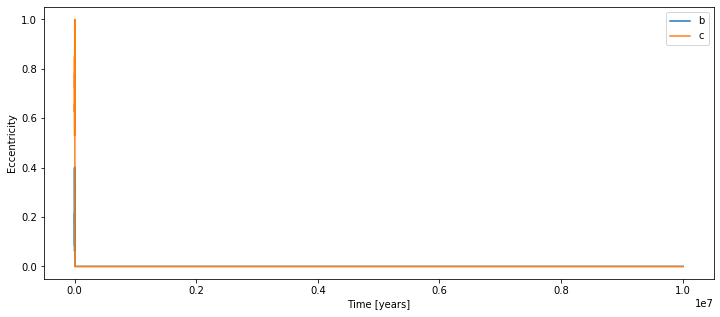

In [5]:
plt.clf()
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
for i in range(Npl):
    plt.plot(times/365., ecc[i], label=labels[i])
ax.set_xlabel("Time [years]")
ax.set_ylabel("Eccentricity")
# plt.xlim(0, 1e5)
plt.legend();

<Figure size 432x288 with 0 Axes>

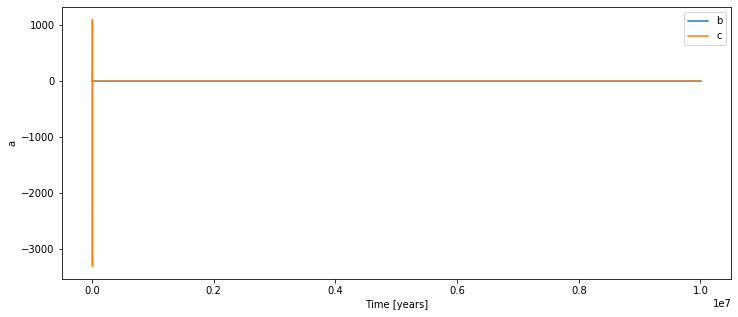

In [6]:
plt.clf()
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
for i in range(Npl):
    plt.plot(times/365, a[i], label=labels[i])
ax.set_xlabel("Time [years]")
ax.set_ylabel("a")
plt.legend();

<Figure size 432x288 with 0 Axes>

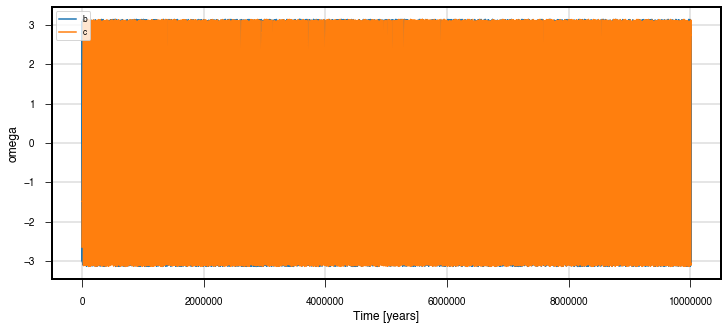

In [9]:
plt.clf()
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
for i in range(Npl):
    plt.plot(times/365, omega[i], label=labels[i])
ax.set_xlabel("Time [years]")
ax.set_ylabel("omega")
# plt.xlim(0, 1e5)
plt.legend();

<Figure size 432x288 with 0 Axes>

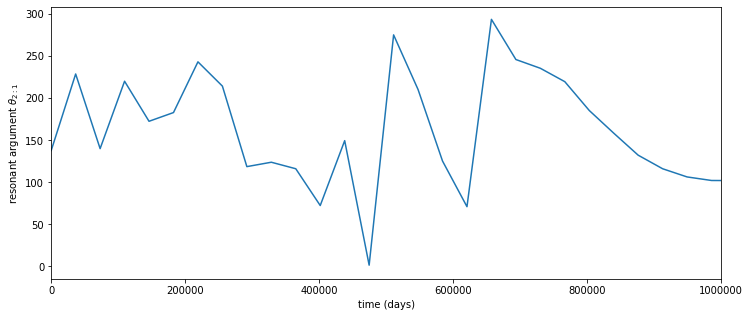

In [7]:
plt.clf()
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
# ax.plot(times,theta)
ax.plot(times,theta_sec) # secular resonance argument
# ax.set_xlim([0,20.*365.25])
# ax.set_ylim([-180,360.])
ax.set_xlabel("time (days)")
ax.set_ylabel(r"resonant argument $\theta_{2:1}$")
plt.xlim(0, 1e6)
ax.plot([0,100],[180,180],'k--')
ax.plot([0,100],[0,0],'k--')

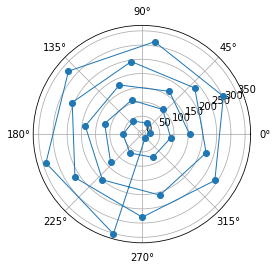

In [12]:
plt.polar(theta_sec[0:30], marker='o', lw=1)
fig = plt.gcf()
display(fig)
plt.close(fig)
clear_output(wait=True)

In [42]:
print(len(theta_sec))

1000


In [12]:
sim.save('simulationarchive.bin')